# OSM Population Prediction Model

## Table of Contents
<ul>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
    <ul>
        <li><a href="#gather">Gather</a></li>
        <li><a href="#assess">Assess</a></li>
        <li><a href="#clean">Clean</a></li>
    </ul>
</li>
<li><a href="#feature_engineering">Feature Engineering</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#helpers">Helper Classes and Methods</a></li>
<li><a href="#ml">Model Training</a></li>
<li><a href="#conclusion">Conclusion</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='introduction'></a>
## Introduction

**How well can we predict the population of a given area based solely on OSM (OpenStreetMap) data?**

The present workflow is a follow up of the first model built in the previous notebook ([`basic_features.ipynb`](./basic_features.ipynb)). Previously we had built the model with only the features present in the dataset gathered from [1], which were somewhat limited and did not provide the required variance to build a robust model, one that can generalize well to unseen cases. As we had seen from the learning curves, we were suffering from bias, and hence, we needed more features to improve our model.

Therefore, a considerable effort was put into building an [application](https://github.com/diogomatoschaves/osm-feature-extractor) that, given a base OSM file and a GeoJSON polygon(s) defining the areas of study, can automatically retrieve several features (~120), and map those to the provided polygons. For more information on these extracted features consult this [page](https://github.com/diogomatoschaves/osm-feature-extractor/blob/master/feature_extractor/feature_augmenting/FEATURES.md).

Thus, we were able to take the existing hexagons and enrich them with more features, which will hopefully improve the score and MSE of the predictions. In this notebook we'll go through the steps of taking this new improved dataset, preparing the data and build a regression model from it. We'll assess the results and compare it with the previous base case.

_Note: In order to make the notebook run faster it's reccommended to use the sample data option (which is True by default), but this will make the final results not as good as if we were using the full dataset. Also, if you run this notebook there can be some variation in the results obtained compared to the values written in the cells, as we're not using the same random seed._

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import re
from itertools import product

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from turf import polygon, area, feature_collection
from scipy.stats import pearsonr
from keplergl import KeplerGl

from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from model.model_evaluation import plot_cities_results, plot_feature_results

In [2]:
# CONFIGURATION

# Set to False if you want to run on the whole data
subset_data = True

all_data_file_name = '../data/hexagons_all_features.geojson'
sample_data_file_name = '../data/hexagons_all_features_sample.geojson'

data_file_name = sample_data_file_name if subset_data else all_data_file_name

<a id='wrangling'></a>
## Data Wrangling

In this section we'll load the data, assess it to check for any quality or tidiness issues and clean where needed.

<a id='gather'></a>
### Gather
As the data was previously gathered from [1], we'll just have to load the geojson as a GeoDataFrame.

In [3]:
df = gpd.read_file(data_file_name)

<a id='assess'></a>
### Assess

In [4]:
map_1 = KeplerGl(height=500)
map_1.add_data(data=df, name="data_1")

map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'data_1': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

In [5]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 129 entries, amenity_education_area to geometry
dtypes: bool(1), float64(76), geometry(1), int64(49), object(2)
memory usage: 29.3+ MB


We have ~350k hexagons (30k if working with sample data) of roughly 0.65 km2, which cover the United Kingdom. 

In [6]:
df["updated"].value_counts()

True     26545
False     3455
Name: updated, dtype: int64

We can see that we have ~40k hexagons that were not updated during the feature collection step (from [osm-feature-extractor](https://github.com/diogomatoschaves/osm-feature-extractor)). This is due to the fact the OSM file used was that of Great Britain, which does not include Northern Ireland. We should remove these from our dataset and only include the ones that were actually updated, even if this will remove some of the hexagons over the area of Sctoland.

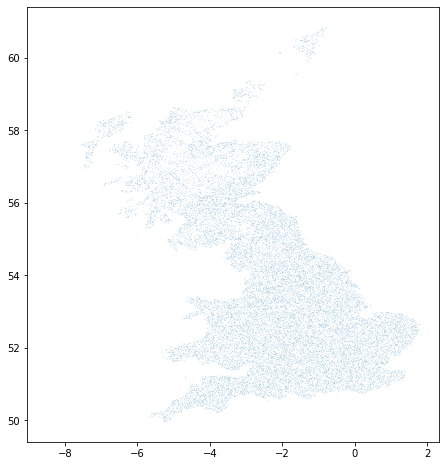

In [7]:
df[df["updated"]].plot(figsize=(8, 8))

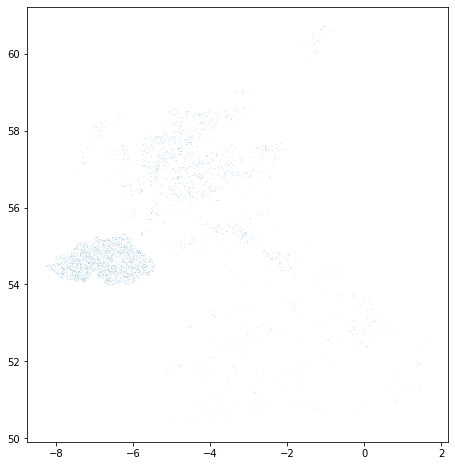

In [8]:
df[~df["updated"]].plot(figsize=(8, 8))

In [9]:
df[df["population"] == 0].shape

(14282, 129)

In [10]:
df["population"].sum()

5428584.0

In [11]:
for col in df.columns:
    if df[col].nunique() == 1:
        print(col)

railway_station_area
ADMIN
ISO_A3


In [12]:
df.columns

Index(['amenity_education_area', 'amenity_education_count',
       'amenity_entertainment_area', 'amenity_entertainment_count',
       'amenity_financial_area', 'amenity_financial_count',
       'amenity_healthcare_area', 'amenity_healthcare_count',
       'amenity_other_area', 'amenity_other_count',
       ...
       'shop_stationery_area', 'shop_stationery_count', 'sport_area',
       'sport_count', 'tourism_area', 'tourism_count', 'updated', 'ADMIN',
       'ISO_A3', 'geometry'],
      dtype='object', length=129)

In [13]:
count_cols = [col for col in df.columns if '_count' in col and col != 'building_count']
length_cols = [col for col in df.columns if '_length' in col and col != 'highway_length']
area_cols = [col for col in df.columns if '_area' in col]

def mean_std_max(cols):
    mean_df = df[cols].mean().to_frame().rename(columns={0: "mean"})
    std_df = df[cols].std().to_frame().rename(columns={0: "std"})
    max_df = df[cols].max().to_frame().rename(columns={0: "max"})
    return pd.merge(pd.merge(mean_df, std_df, left_index=True, right_index=True), max_df, left_index=True, right_index=True)

In [14]:
mean_std_max(count_cols).sort_values(by="mean", ascending=False)[:10]

,mean,std,max
building_accommodation_count,11.277833,80.357508,2001
building_other_count,10.438400,60.660728,1674
natural_count,1.985900,29.449613,1829
power_count,1.604567,6.674081,352
highway_bus_stop_count,0.690300,2.621491,64
building_cars_count,0.684600,9.571348,622
amenity_other_count,0.628900,3.759999,190
building_commercial_count,0.414033,5.166982,444
highway_crossing_count,0.255433,1.990256,84
amenity_sustenance_count,0.239467,2.431499,236


In [15]:
mean_std_max(length_cols).sort_values(by="mean", ascending=False)[:10]

,mean,std,max
highway_footway_length,468.338062,914.258184,18485.45
highway_residential_length,388.616903,1312.201991,12675.80
highway_service_length,375.668131,801.985761,22208.87
highway_tertiary_length,166.593116,383.528677,4241.01
railway_rail_length,102.871922,568.454567,22814.65
natural_length,87.195173,361.710891,11527.76
highway_secondary_length,86.012832,261.632818,2436.77
highway_primary_length,80.229102,280.583634,5035.05
highway_trunk_length,80.223625,334.246256,6789.72
highway_cycleway_length,54.020495,267.976941,6065.80


In [16]:
mean_std_max(area_cols).sort_values(by="mean", ascending=False)[:10]

,mean,std,max
landuse_agricultural_area,97844.525845,182015.144681,1256925.82
natural_area,71420.782272,148850.023737,1514031.10
landuse_residential_area,27143.601970,87132.800143,1300622.42
leisure_area,12345.694234,60315.523749,1245152.68
landuse_industrial_area,4934.620147,33224.843427,844903.45
landuse_other_area,4185.162142,42572.878301,884284.75
building_other_area,2324.607231,10254.794091,230472.14
military_area,2135.546348,34217.477346,701684.90
amenity_education_area,1877.229519,12079.328773,448324.20
sport_area,1768.203284,15935.873341,847942.71


<a id='clean'></a>
### Clean

As dicussed previously, we should only include in the model the hexagons that were updated during the feature augmenting.

In [17]:
df = df[df["updated"]].copy()
df.head(2)

,amenity_education_area,amenity_education_count,amenity_entertainment_area,amenity_entertainment_count,amenity_financial_area,amenity_financial_count,amenity_healthcare_area,amenity_healthcare_count,amenity_other_area,amenity_other_count,...,shop_stationery_area,shop_stationery_count,sport_area,sport_count,tourism_area,tourism_count,updated,ADMIN,ISO_A3,geometry
1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,True,United Kingdom,GBR,"POLYGON ((-3.82238 56.05852, -3.81603 56.05546..."
2,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,True,United Kingdom,GBR,"POLYGON ((-3.00768 57.08796, -3.00116 57.08488..."


Furthermore, we can define the columns we know we don't want to include in the model, be it because they are not given by the [osm-feature-extractor](https://github.com/diogomatoschaves/osm-feature-extractor), or because they just can't be included in the model (eg. `geometry`). However, as we still might need some of them (eg. `geometry`), we'll defer the filtering to be done on a step of the ML pipeline instead.

In [18]:
features_to_delete = ['id', 'updated', 'ADMIN', 'ISO_A3', 'building_count', 'area', 'count', 'osm_users', 'geometry', 'gdp', 'population', 'area_km2', 'highway_length']

In [19]:
features = [col for col in df.columns if col not in features_to_delete]
target = 'population'

In order to make the model more general and less prone to overfitting on outliers, we'll apply a rule to delete the data points that are larger or smaller than the 99.99 and 0.01 percentiles respectively. This makes sure that only the relatively extreme values get deleted.

In [20]:
def detect_outliers(column, df=df):
    
    min_value = df[column].quantile(q=0.0001)
    max_value = df[column].quantile(q=0.9999)
    
    try:
        outliers = df[(df[column] > max_value) | (df[column] < min_value)]
    except IndexError:
        outliers = None
    
    return outliers

In [21]:
outliers = set()

for feature in features:

    new_outliers = detect_outliers(feature)
    
    if new_outliers is None:
        continue
        
    outliers.update(new_outliers.index)
    

In [22]:
df[df.index.isin(outliers)]

,amenity_education_area,amenity_education_count,amenity_entertainment_area,amenity_entertainment_count,amenity_financial_area,amenity_financial_count,amenity_healthcare_area,amenity_healthcare_count,amenity_other_area,amenity_other_count,...,shop_stationery_area,shop_stationery_count,sport_area,sport_count,tourism_area,tourism_count,updated,ADMIN,ISO_A3,geometry
139,56371.32,0,0.00,0,213.55,0,1281.25,0,38877.59,30,...,0.0,0,92439.11,3,0.00,2,True,United Kingdom,GBR,"POLYGON ((-1.56195 54.77772, -1.55594 54.77455..."
228,23718.24,0,4725.85,3,0.00,7,0.00,2,3295.85,89,...,0.0,8,0.00,0,3568.81,15,True,United Kingdom,GBR,"POLYGON ((-2.99995 53.65573, -2.99395 53.65257..."
243,89609.54,1,244.60,0,0.00,6,39568.56,3,2861.94,43,...,0.0,0,7409.05,1,1073.16,10,True,United Kingdom,GBR,"POLYGON ((-0.04068 51.53203, -0.03519 51.52872..."
287,76307.41,0,0.00,0,0.00,0,1202.35,0,0.00,5,...,0.0,0,5314.21,0,0.00,0,True,United Kingdom,GBR,"POLYGON ((-1.51114 50.92868, -1.50547 50.92544..."
388,0.00,0,0.00,0,0.00,0,0.00,0,0.00,6,...,0.0,0,0.00,0,0.00,0,True,United Kingdom,GBR,"POLYGON ((-0.12136 51.37725, -0.11587 51.37392..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29786,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,...,0.0,0,0.00,0,0.00,0,True,United Kingdom,GBR,"POLYGON ((-2.81937 56.30882, -2.81319 56.30568..."
29829,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,...,0.0,0,0.00,0,0.00,0,True,United Kingdom,GBR,"POLYGON ((-2.95790 51.18236, -2.95223 51.17924..."
29847,0.00,0,0.00,0,0.00,0,0.00,0,11670.26,0,...,0.0,0,0.00,0,0.00,0,True,United Kingdom,GBR,"POLYGON ((-1.40436 53.40861, -1.39870 53.40534..."
29853,248.06,0,0.00,2,0.00,1,1722.02,1,147.55,57,...,0.0,1,74681.13,4,595.07,7,True,United Kingdom,GBR,"POLYGON ((-0.00893 51.55466, -0.00343 51.55135..."


In [23]:
df = df[~df.index.isin(outliers)].copy()

We can now exclude columns that have only one value, as they won't contribute with any information to our model.

In [24]:
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(columns=col, inplace=True)

In [25]:
features = [col for col in df.columns if col not in features_to_delete]

In [26]:
features

['amenity_education_area',
 'amenity_education_count',
 'amenity_entertainment_area',
 'amenity_entertainment_count',
 'amenity_financial_area',
 'amenity_financial_count',
 'amenity_healthcare_area',
 'amenity_healthcare_count',
 'amenity_other_area',
 'amenity_other_count',
 'amenity_sustenance_area',
 'amenity_sustenance_count',
 'amenity_transportation_area',
 'amenity_transportation_count',
 'building_accommodation_area',
 'building_accommodation_count',
 'building_agricultural_area',
 'building_agricultural_count',
 'building_cars_area',
 'building_cars_count',
 'building_civic_area',
 'building_civic_count',
 'building_commercial_area',
 'building_commercial_count',
 'building_other_area',
 'building_other_count',
 'building_power_area',
 'building_power_count',
 'building_religious_area',
 'building_religious_count',
 'building_sports_area',
 'building_sports_count',
 'building_storage_area',
 'building_storage_count',
 'craft_area',
 'craft_count',
 'emergency_area',
 'emergen

All features are numeric, so there's no need for performing one hot enconding on any variable. Thus, no further data wrangling is required.

<a id='feature_engineering'></a>
## Feature Engineering

As we'll normalize all the values by the area, we need to calculate it for each polygon respectively. 

In [27]:
def get_regex_matches(regex_str):

    pattern = r"\((.*?)\)"

    matches = re.findall(pattern, regex_str)

    matches = [match.replace("(", "").replace(")", "").split(", ") for match in matches]

    return matches

def handle_multi_polygon(multi_polygon):

    matches = get_regex_matches(multi_polygon)

    polygons = []

    for match in matches:

        coords = [[[float(c) for c in coord.split(" ")] for coord in match]]

        try:
            polygons.append(polygon(coords))
        except InvalidInput:
            coords[0].append(coords[0][0])
            polygons.append(polygon(coords))

    return feature_collection(polygons)

In [28]:
def calculate_area(poly):
    
    if poly.geom_type == 'MultiPolygon':
        coords = handle_multi_polygon(poly.wkt)
    else:          
        coords = [list(coord) for coord in poly.exterior.coords]

    return area([coords]) / 1E6


In [29]:
df['area'] = df['geometry'].apply(lambda poly: calculate_area(poly))

<a id='eda'></a>
## Exploratory Data Analysis

In this section we'll visualize some plots and graphs to help us get a better grasp of the data at hand. We'll start by visualising the correlation between all variables and the target variable - `population`.

In [30]:
correlations, pvalues = [], []
for column in features:            
    r, p = pearsonr(df[column], df['population'])
    
    correlations.append(r)
    pvalues.append(p)
    
df_corr = pd.DataFrame(index=features, 
                       data={'correlation': correlations})
df_pvalues = pd.DataFrame(index=features, 
                       data={'p_values': pvalues})

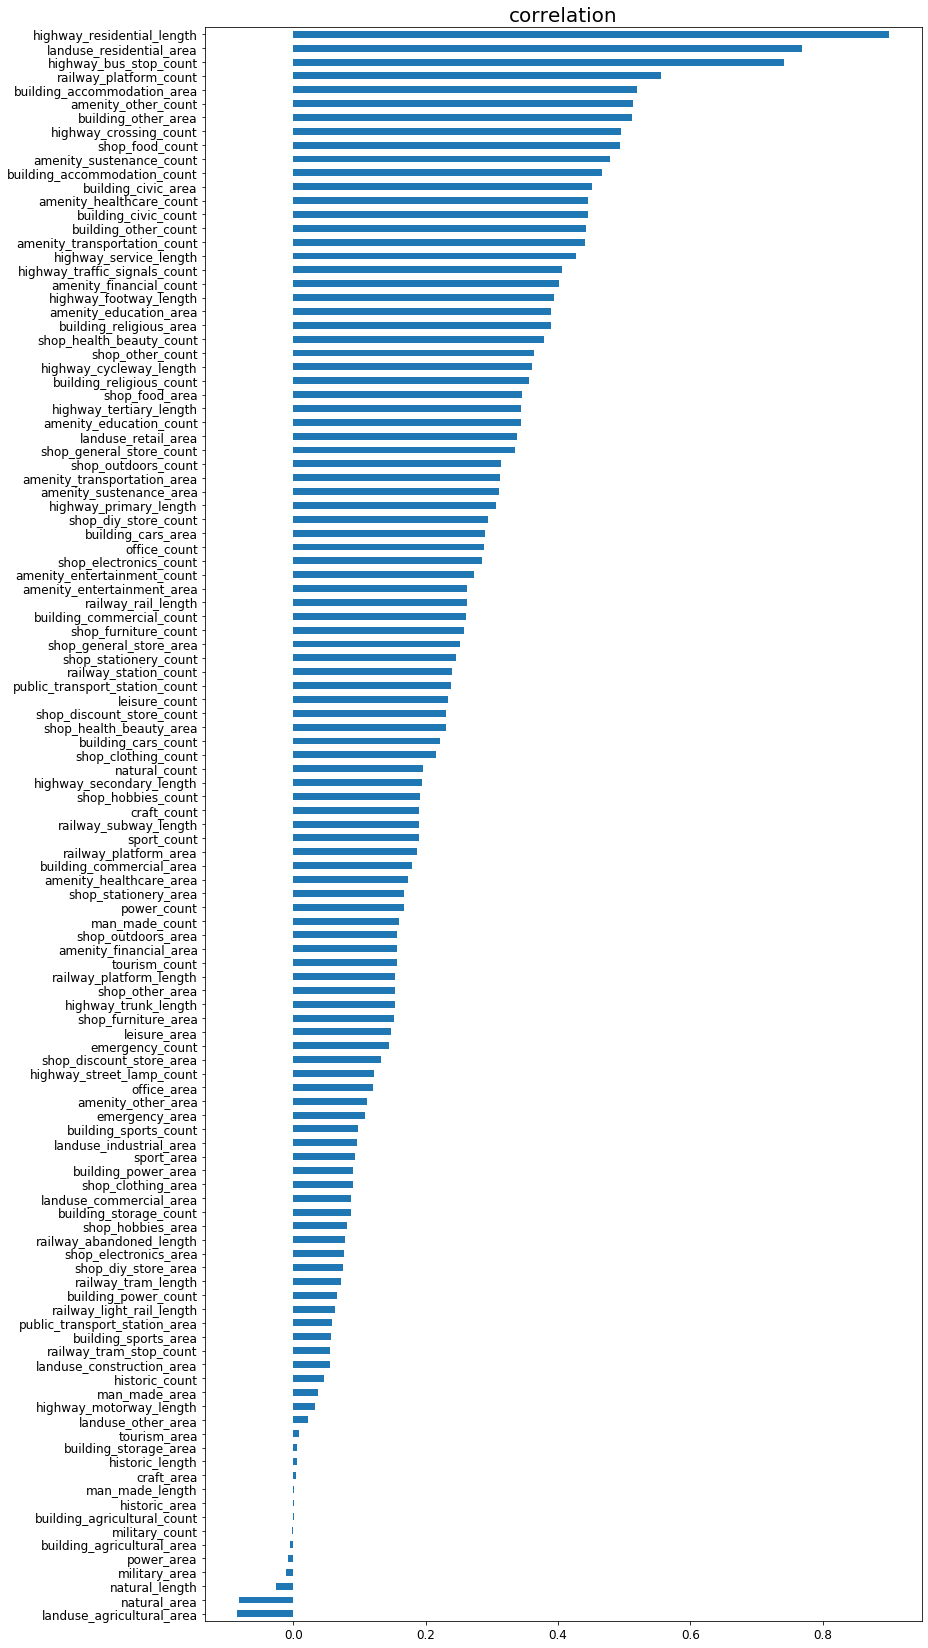

In [31]:
plt.figure(figsize=(13, 23))

df_corr['correlation'].sort_values().plot(kind='barh', fontsize=12, 
                                  ax=plt.gca(), color='C0');
plt.title('correlation', fontsize=20);
plt.tight_layout();

We can see that the variables with highest positive correlation are `highway_residential_length` and `landuse_residential_area`. This is somewhat expected, as these variables are associated with residential areas, and thus, populated places. On the opposite end, the variables with highest negative correlation are `natural_area` and `landuse_agricultural_area`, which is again expected, as these type of features are associated with low population density. 

Let's analyze some selected features a bit more in depth. 

In [32]:
selected_features = [
    'highway_residential_length',
    'shop_food_count',
    'landuse_residential_area', 
    'highway_bus_stop_count',
    'building_accommodation_count',
    'railway_platform_count',
    'natural_area',
    'landuse_agricultural_area',
    'population'
]

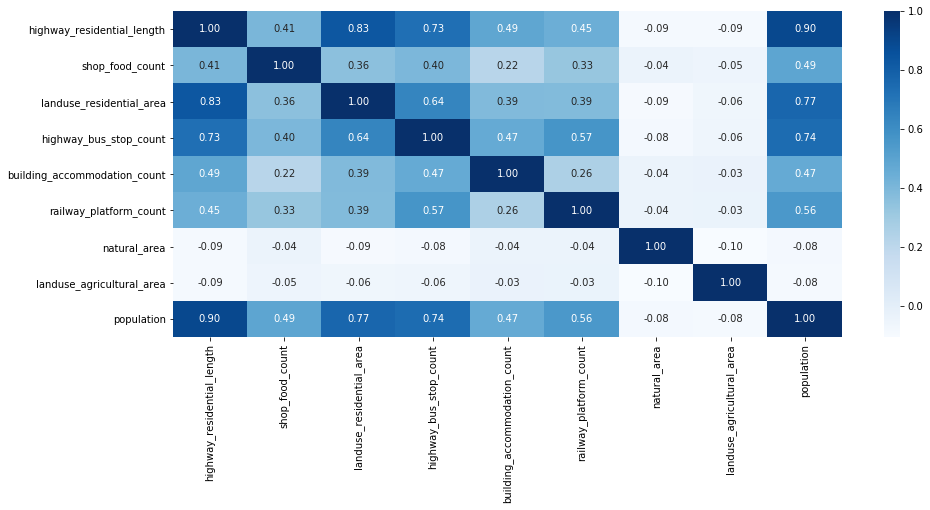

In [33]:
plt.figure(figsize=(15, 6))
sb.heatmap(df[selected_features].corr(), annot=True, fmt=".2f", cmap='Blues');

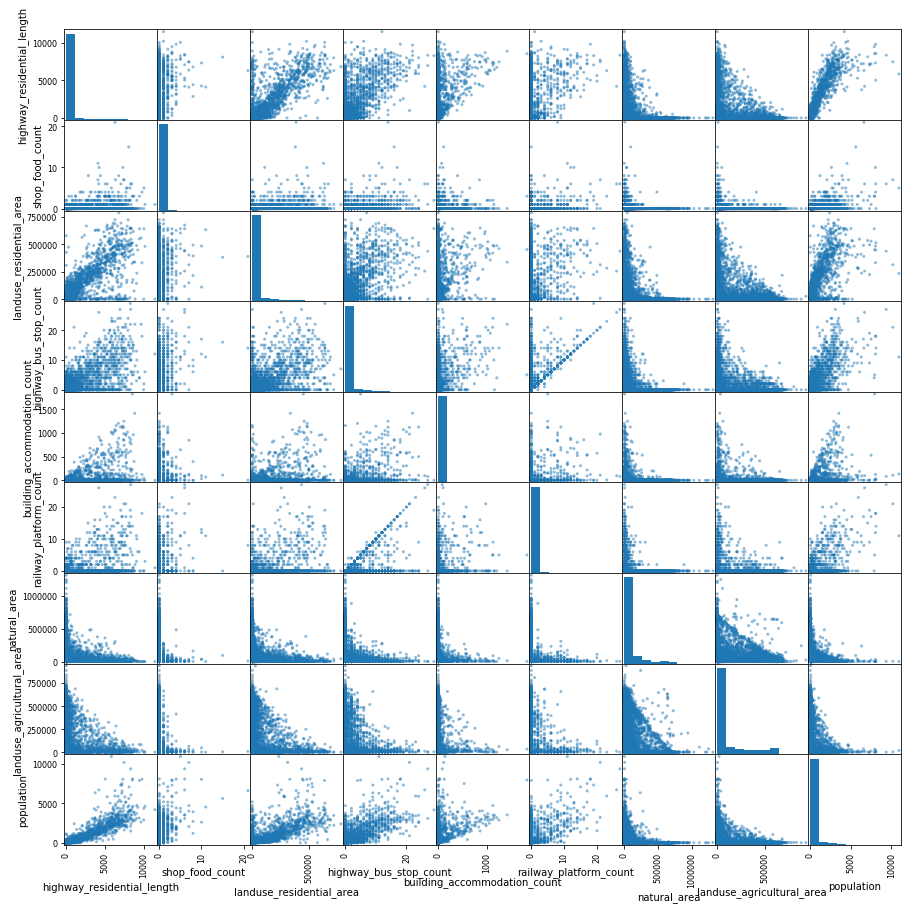

In [34]:
pd.plotting.scatter_matrix(df[selected_features].sample(10000), figsize=(15, 15));

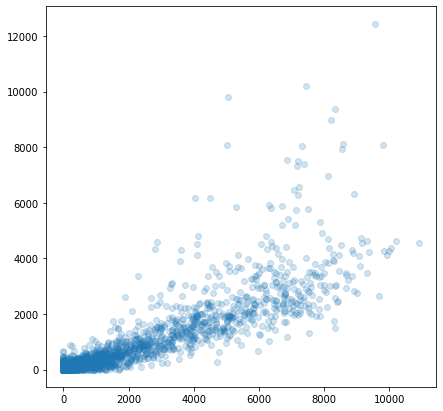

In [35]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df.sample(10000), x='highway_residential_length', y='population', alpha=0.2);

As expected due to the high correlation, the distribution between `highway_residential_length` and `population` follows quite strongly a straight line. 

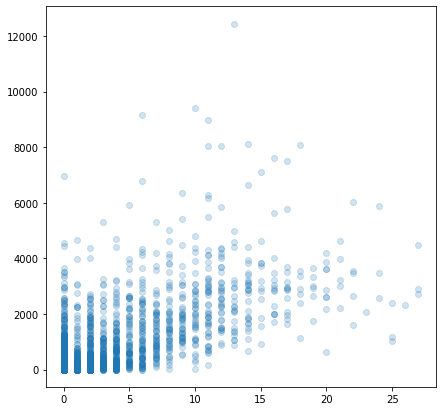

In [36]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df.sample(10000), x='highway_bus_stop_count', y='population', alpha=0.2);

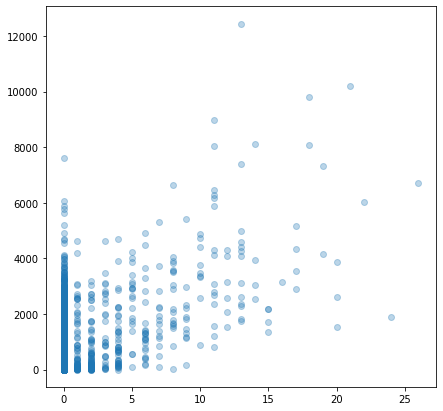

In [37]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df.sample(10000), x='railway_platform_count', y='population', alpha=0.3);

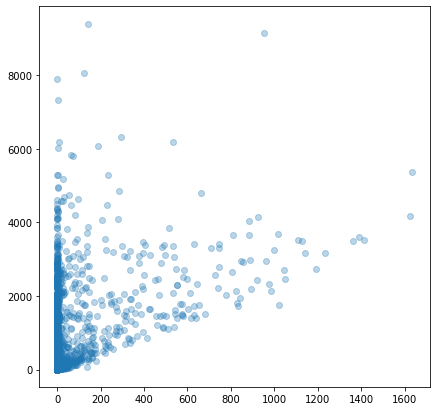

In [38]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df.sample(10000), x='building_accommodation_count', y='population', alpha=0.3);

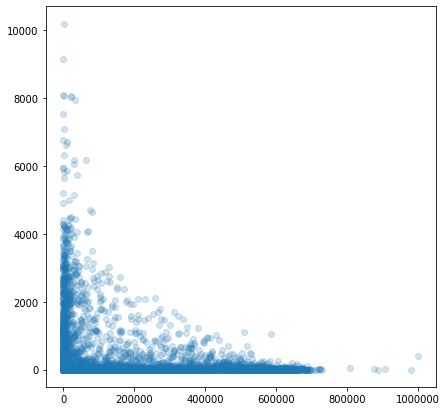

In [39]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df.sample(10000), x='landuse_agricultural_area', y='population', alpha=0.2);

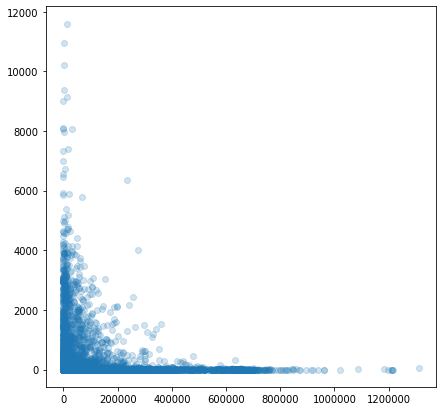

In [40]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df.sample(10000), x='natural_area', y='population', alpha=0.2);

The 2 plots above depict a relationship that is more parabolic than linear. This points to making us consider using polynomials of the features to build these kind of more complex relationships in the model.

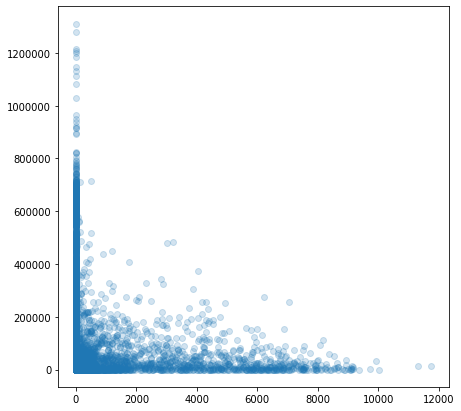

In [41]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df.sample(10000), x='highway_residential_length', y='natural_area', alpha=0.2);

<a id='helpers'></a>
## Helper Classes and Methods

In [42]:
def feature_mapping(x, order, intercept=False, only_self_terms=False):
    """
    Maps the original features up to the chosen degree.
    Example for initial features a and b and chosen order of 3:
    [a b a^2 ab b^2 a^3 a^2b ab^2 b^3]
    :param x: array like object of m examples by n features
    :param order: order of the polynomial expansion mapping to perform
    :param intercept: If return array should include the intercept column
    :param only_self_terms: if should only include polynomial terms (eg: x, x2, x3, etc)
    :return: array with mapped features
    """
    X = np.array(x).copy()

    n_features = X.shape[1] if len(X.shape) > 1 else 1
    features = [i for i in range(n_features)]

    for i in range(2, order + 1):

        if only_self_terms:

            for j in features:
                # X = np.hstack((X, X[:, j] ** i))
                X = np.c_[X, X[:, j] ** i]

        else:
            product_cases = list(product(features, repeat=i))

            product_cases = [tuple(sorted(t)) for t in product_cases]
            product_cases = list(set(product_cases))

            for case in product_cases:

                columns = np.array([x[:, int(col)] for col in case]).T
                columns_prod = np.cumprod(columns, axis=1)[:, -1].reshape(-1, 1)

                X = np.hstack((X, columns_prod))

    if intercept:
        X = np.c_[np.ones(X.shape[0]), X]

    return X

In [43]:
def plot_learning_curve(estimator, title, X, y, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(0.1, 1.0, 10),
                        metric='neg_mean_squared_error'
                       ):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(8, 18))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Error")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, 
                       scoring=metric
                      )
    
    train_scores = np.abs(train_scores)
    test_scores = np.abs(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation error")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Error")
    axes[2].set_title("Performance of the model")

    return train_sizes, train_scores, test_scores, fit_times

In [44]:
class CalculateArea(BaseEstimator, TransformerMixin):
    
    def calculate_area(idx, poly):
                
        coords = [list(coord) for coord in poly.exterior.coords]
        
        poly = polygon([coords])
                
        return calculate_area(poly) / 1E6

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        X_copy = X.copy()
        
        if 'area' not in X.columns:
            X_copy['area'] = X_copy['geometry'].apply(lambda poly: self.calculate_area(poly))
                
        return X_copy

In [45]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        X_copy = X.copy()
        
        X_copy = X_copy[self.columns]
        
        return X_copy

In [46]:
class AreaNormalizer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        X_copy = X.copy()
        
        if 'area' in X:
            for col in X_copy:
                X_copy[col] = X_copy[col] / X_copy['area']
        
        return pd.DataFrame(X_copy)

In [47]:
class RemoveColumn(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        X_copy = X.drop(columns=self.columns)
        
        return X_copy

In [48]:
class FeaturePolynomial(BaseEstimator, TransformerMixin):
    
    def __init__(self, order, only_self_terms=True):
        self.order = order
        self.only_self_terms = only_self_terms
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        poly_X = feature_mapping(X.to_numpy(), self.order, only_self_terms=self.only_self_terms)
        
        return poly_X

<a id='ml'></a>
## Model Training

In this section we'll be fitting the data to the chosen regression algorithm. For that, we'll split the data in training and test examples, and build the machine learning pipeline. This chosen pipeline is a sequence of steps that encapsulates some transformations, some required and some optional. The main model design decision here was to normalize all features by the are corresponding area, as that proved to make the model generalize to larger areas much better. Below the steps of the pipeline are briefly described:

1. `calculate_area`: This step calculates the area of inut data if it is not calculated already
2. `feature_selector`: This step selects the model features + the `area`, as it will be used in the next step.
3. `area_normalizer`: This step normalizes each feature by the area corresponding to that input data.
4. `remove_columns`: This step removes unrequired columns; in this case `area`
5. `feature_mapping`: This step adds features which are the exponiented input features, up to a specified degree
6. `scaling`: This step scales the features by subtracting the mean and dividing by the standard deviation
7. `reg`: This step is when the regression happens, where the data is finally fitted into the chosen algorithm.

We divide the target variable (`population`) by the `area`, but leave the same process for the features as a step on the ML pipeline - the `AreaNormalizer` class.

In [49]:
X = df
y = df[target] / df['area']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

We can define the pipeline as detailed above and do a first fitting of the data to get a sense of the results. We'll use as a first approach a **Lasso** Regressor:

In [51]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(1, True)),
    ('scaling', StandardScaler()),
    ('reg', Lasso(alpha=1)),
])

In [52]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('calculate_area', CalculateArea()),
                ('feature_selector',
                 FeatureSelector(columns=['amenity_education_area',
                                          'amenity_education_count',
                                          'amenity_entertainment_area',
                                          'amenity_entertainment_count',
                                          'amenity_financial_area',
                                          'amenity_financial_count',
                                          'amenity_healthcare_area',
                                          'amenity_healthcare_count',
                                          'amenity_other_area',
                                          'amenit...
                ('remove_columns', RemoveColumn(columns=['area'])),
                ('feature_mapping',
                 FeaturePolynomial(only_self_terms=True, order=1)),
                ('scaling',
             

In [53]:
pipeline.score(X_test, y_test)

0.8556604819557234

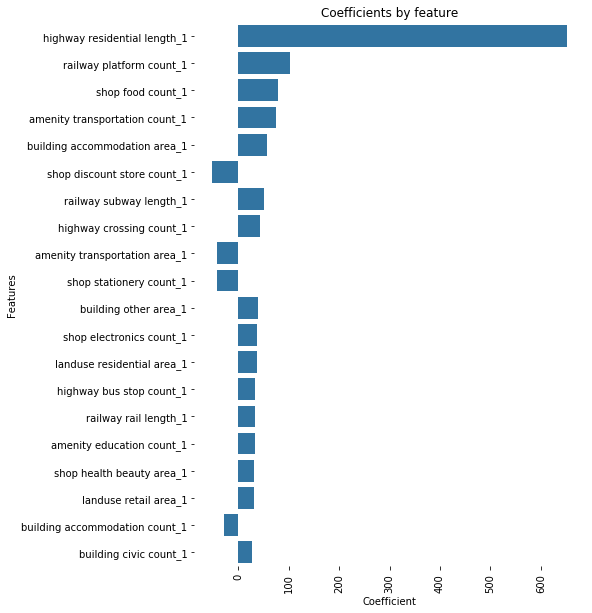

In [54]:
plot_feature_results(pipeline, features)

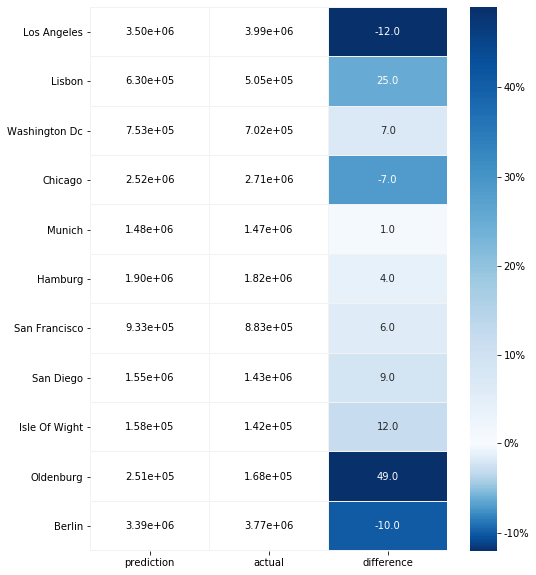

In [55]:
plot_cities_results(pipeline, '../data/population_tests')

We see that we get a score of ~0.86, a sizable improvement with regards to the previous base case just by using more features! We can now perform hyperparameter tuning in order to find the best combination of parameters.

In [56]:
params = {
    "feature_mapping__order": [1, 2, 3],
    "reg": [Ridge(), Lasso()],
    "reg__alpha": [1, 2, 3, 4, 5, 10, 50],
}

In [57]:
grid = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('calculate_area', CalculateArea()),
                                       ('feature_selector',
                                        FeatureSelector(columns=['amenity_education_area',
                                                                 'amenity_education_count',
                                                                 'amenity_entertainment_area',
                                                                 'amenity_entertainment_count',
                                                                 'amenity_financial_area',
                                                                 'amenity_financial_count',
                                                                 'amenity_healthcare_area',
                                                                 'amenity_he...
                                       fit_intercept=T

In [58]:
grid.best_score_

0.878102229857251

In [59]:
grid.best_params_

{'feature_mapping__order': 2,
 'reg': Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
       positive=False, precompute=False, random_state=None, selection='cyclic',
       tol=0.0001, warm_start=False),
 'reg__alpha': 10}

We can see that the best combination of parameters is to use the **Lasso** regressor, a polynomial degree of `2` and a regularization parameter (`alpha`) of 10. Let's fit the data using those parameters.

In [60]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(2)),
    ('scaling', StandardScaler()),
    ('reg', Lasso(alpha=10)),
])

In [61]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('calculate_area', CalculateArea()),
                ('feature_selector',
                 FeatureSelector(columns=['amenity_education_area',
                                          'amenity_education_count',
                                          'amenity_entertainment_area',
                                          'amenity_entertainment_count',
                                          'amenity_financial_area',
                                          'amenity_financial_count',
                                          'amenity_healthcare_area',
                                          'amenity_healthcare_count',
                                          'amenity_other_area',
                                          'amenit...
                ('remove_columns', RemoveColumn(columns=['area'])),
                ('feature_mapping',
                 FeaturePolynomial(only_self_terms=True, order=2)),
                ('scaling',
             

In [62]:
pipeline.score(X_test, y_test)

0.858776189604219

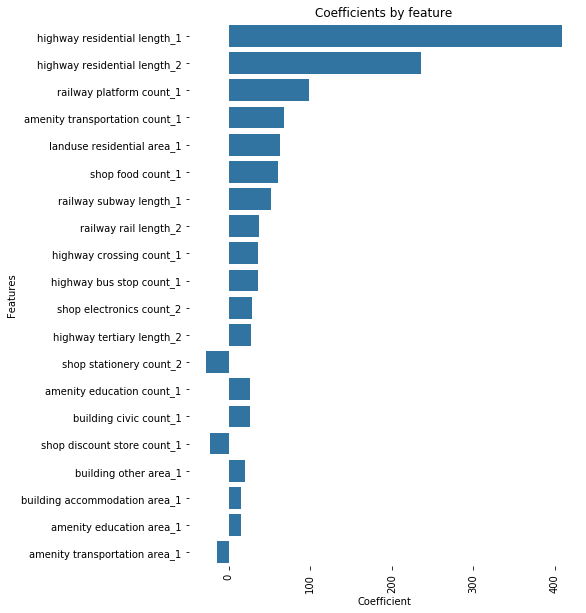

In [63]:
plot_feature_results(pipeline, features)

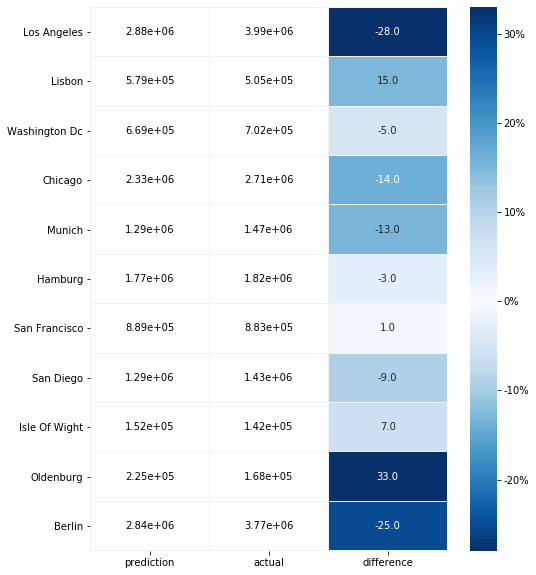

In [64]:
plot_cities_results(pipeline, '../data/population_tests')

We were able to obtain an improvement with the hypertuning, and went from a score of ~0.868 to ~0.878. We can look at the learning curves in order to get a sense of where we stand in relation to the bias-variance trade off.

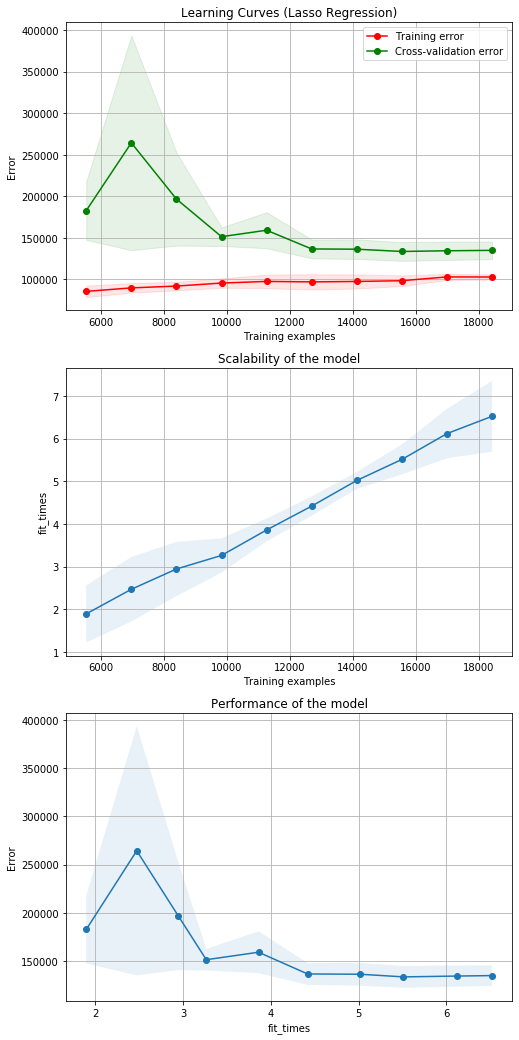

In [65]:
title = "Learning Curves (Lasso Regression)"

cv = ShuffleSplit(n_splits=3, test_size=0.3)

train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(pipeline, title, X, y, cv=cv, train_sizes=np.linspace(0.3, 1, 10))

By looking at the learning curves we see that, compared to the case of using less features, we were able to greatly bring the mean squared error down, and have the training and cross validation errors converge at a lower value.

Let's try now to build a model with other type of regressors, such as the **RandomForestRegressor** and the **GradientBoostingRegressor**, which, as opposed to the previous ones we used, are stochastic. As we did with the previous regressors, let's first try with some default values the **RandomForestRegressor** to get a sense of the results we get.

In [66]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(1)),
    ('pre-processing', StandardScaler()),
    ('reg', RandomForestRegressor()),
])

In [67]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('calculate_area', CalculateArea()),
                ('feature_selector',
                 FeatureSelector(columns=['amenity_education_area',
                                          'amenity_education_count',
                                          'amenity_entertainment_area',
                                          'amenity_entertainment_count',
                                          'amenity_financial_area',
                                          'amenity_financial_count',
                                          'amenity_healthcare_area',
                                          'amenity_healthcare_count',
                                          'amenity_other_area',
                                          'amenit...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_no

In [68]:
pipeline.score(X_test, y_test)

0.8723008129261616

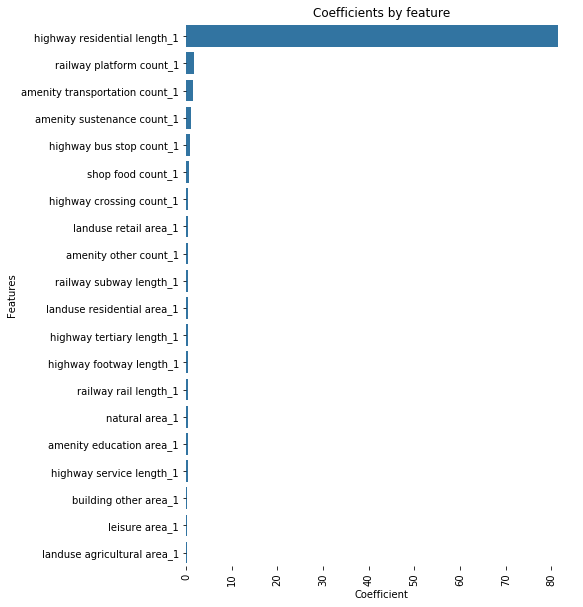

In [69]:
plot_feature_results(pipeline, features)

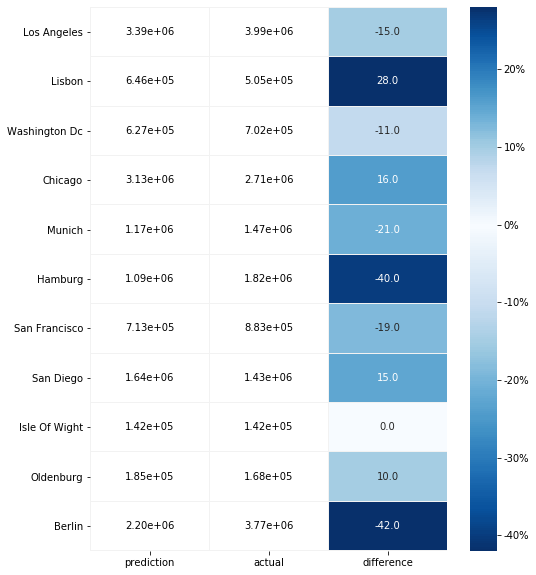

In [70]:
plot_cities_results(pipeline, '../data/population_tests')

This score of ~0.872 provides from the get-go a similar score to the one using the tuned **Lasso** regressor. We'll now perform hyperparameter tuning in order to find the best combination of parameters for these regressors.

In [71]:
params = {
    'feature_mapping__order': [1, 2, 3],
    'reg': [RandomForestRegressor(), GradientBoostingRegressor()],
    'reg__max_leaf_nodes': [100, 200, None],
    'reg__n_estimators': [100, 200],
    'reg__max_features': ['auto', 'sqrt']
}

In [72]:
grid = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('calculate_area', CalculateArea()),
                                       ('feature_selector',
                                        FeatureSelector(columns=['amenity_education_area',
                                                                 'amenity_education_count',
                                                                 'amenity_entertainment_area',
                                                                 'amenity_entertainment_count',
                                                                 'amenity_financial_area',
                                                                 'amenity_financial_count',
                                                                 'amenity_healthcare_area',
                                                                 'amenity_he...
                                                      

In [73]:
grid.best_score_

0.8907836736586878

In [74]:
grid.best_params_

{'feature_mapping__order': 3,
 'reg': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=100,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 'reg__max_features': 'sqrt',
 'reg__max_leaf_nodes': 100,
 'reg__n_estimators': 200}

The best parameters are to use 200 estimators, a maximum of the square root of the features and 100 maximum leaf nodes. We can now add those paramters to our pipeline and calculate the final score.

In [75]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(3)),
    ('pre-processing', StandardScaler()),
    ('reg', GradientBoostingRegressor(n_estimators=200, max_features='sqrt', max_leaf_nodes=None)),
])

In [76]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('calculate_area', CalculateArea()),
                ('feature_selector',
                 FeatureSelector(columns=['amenity_education_area',
                                          'amenity_education_count',
                                          'amenity_entertainment_area',
                                          'amenity_entertainment_count',
                                          'amenity_financial_area',
                                          'amenity_financial_count',
                                          'amenity_healthcare_area',
                                          'amenity_healthcare_count',
                                          'amenity_other_area',
                                          'amenit...
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features='sqrt',
                                           max_leaf_nodes=None,

In [77]:
pipeline.score(X_test, y_test)

0.8732255976601383

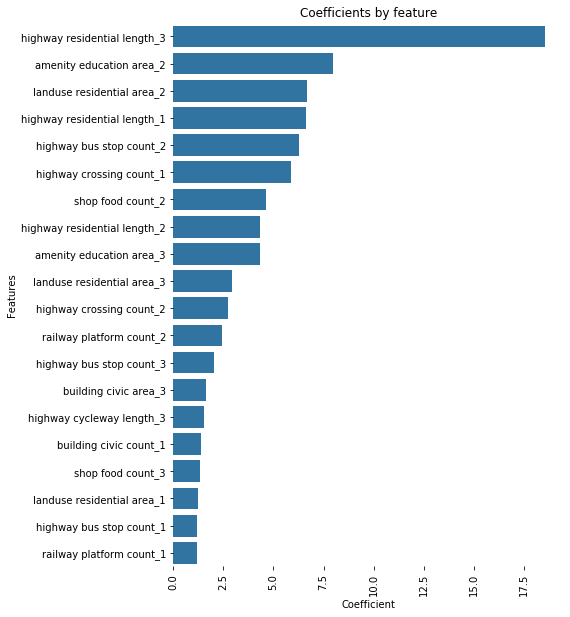

In [78]:
plot_feature_results(pipeline, features)

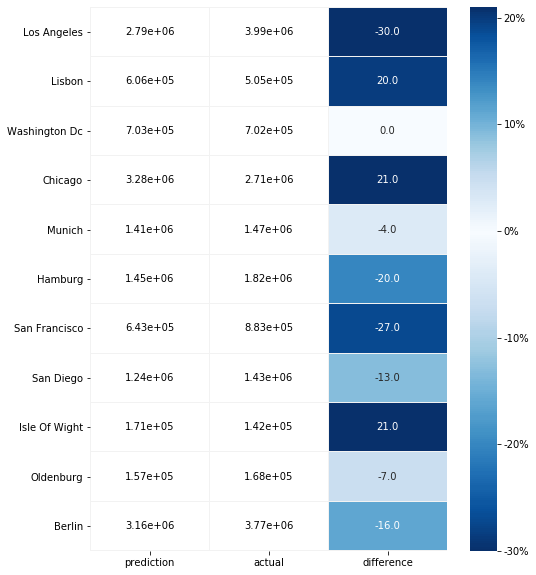

In [79]:
plot_cities_results(pipeline, '../data/population_tests')

We obtained a final score of 0.873. We can look at the learning curves in order to get a sense of where we stand in relation to the bias-variance trade off.

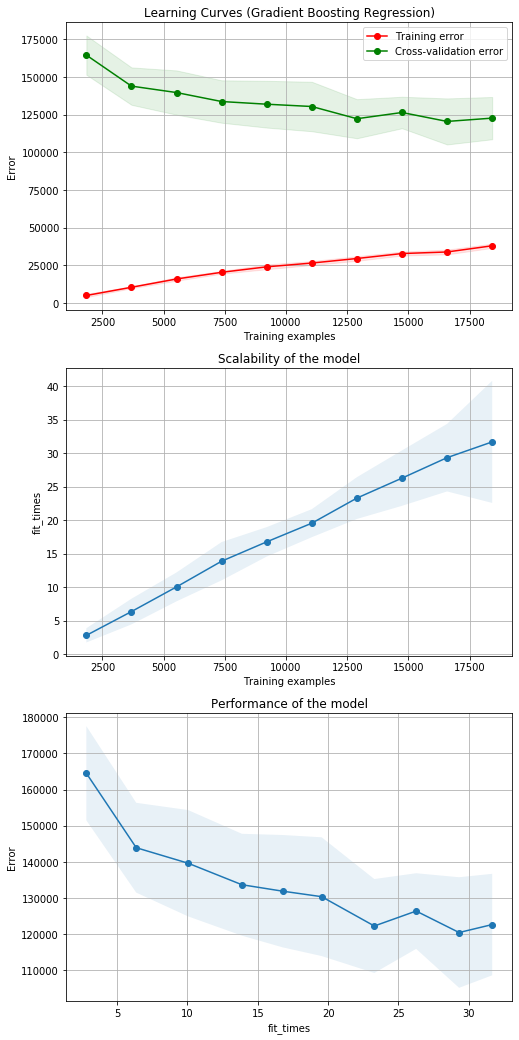

In [80]:
title = "Learning Curves (Gradient Boosting Regression)"

cv = ShuffleSplit(n_splits=3, test_size=0.3)

train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(pipeline, title, X, y, cv=cv)

Here we see that we have a low training error and higher (but still relatively low) cross validation error, which suggests that we have a certain overfitting on the data. In this case having more data would help to counteract this fact and help the model to extend even better to unseen cases.

<a id="conclusion"></a>
## Conclusion

In this project we set out to build a model that could accurately predict the population of a given area, based solely on features extracted from OSM data. For this we started first with a dataset taken from [1], which was characterized by having few features, and thus, resulting in a high bias model. In this present notebook we extended the base data with extracted features taken from OSM files using a custom-built [application](https://github.com/diogomatoschaves/osm-feature-extractor).

We again used 2 types of regressors for building a model with this new data: linear (**Ridge** and **Lasso**) and ensemble (**Random Forest** and **Gradient Boosting**) models. The ensemble models proved to result in higher scores on the test data, although the linear ones produced better results for population predictions of actual places and cities. 

We saw that the addition of more features, although risking adding some noise to the model, provided a much improved predictive capacity, and allowed us to greatly reduce the mean squared error. Also, with this approach we have a way of deterministically extracting all the required input features from OSM data using [application](https://github.com/diogomatoschaves/osm-feature-extractor), as opposed to just using the initial data, which we did not have out of the box a way of determining the features for new areas whitout having to perform some sort of reverse engineering.

Population prediction is an inherently difficult task, as population numbers fluctuate considerably while the underlying infrastructure remains relatively the same. In this model we used data points that spread across the UK, which spans areas of very high density (such as London), as well as areas of less desnity and of farmland. This should enable the model to extend well to most cases, although probably not so well if we were to use it in areas of very high population density. Also, the model is dependent on how well mapped the area in study is. In most of the western world the OSM extracts are quite well mapped, but it's less so the case in more developing places, although the main centers of population in general tend to be well mapped. Despite these facts, we saw that the model predicted the population of actual places and cities with relatively low error, and we now have a model that can make rough estimates on the population of any given area based solely on its OSM features.

In order to further improve this work, we could perform a thorough Feature Selection analysis, in order to determine which variables would represent the maximum relevance and minimum redundancy. Perhaps with this study we would understand which variables are contributing to the bias in the real population predictions when we use ensemble methods, which scored higher but produced worse actual population predictions.

We could also improve and fine tune the feature extraction strategy, creating more complex features such as if buildings are attached to each other, or if roads are oneway or two way. 

<a id='references'></a>
## References

[1] - [Kontur Population: Global Population Density for 400m H3 Hexagons](https://data.humdata.org/dataset/kontur-population-dataset) <br>